In [1]:
import numpy as np
import pandas as pd
from timeit import default_timer as timer

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as gnn
from torch_geometric import datasets
from torch_geometric.loader import DataLoader

from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
DEVICE="cuda"
torch.manual_seed(1)
np.random.seed(1)

In [111]:
computers = datasets.Amazon(root='/tmp/Computers', name='Computers').to(DEVICE)
mnist = datasets.GNNBenchmarkDataset(root='/tmp/MNIST', name='MNIST').to(DEVICE)


In [4]:
def train_split(data, graph_wise=False):
    if graph_wise:
        split=torch.randint(5,size=(len(data),))
        return data[(split<=2)],data[(split==3)],data[(split==4)]
    else:
        split=torch.randint(5,size=(len(data[0].y),))
        return (split<=2),(split==3),(split==4)


In [5]:
class ResGNN(nn.Module):
    def __init__(self, num_node_features, num_classes, layersize=16, layers=4, wt_groups=None, graph_wise=False, dropout=0.0):
        super().__init__()
        if (wt_groups is None):
            wt_groups=layers
        self.wt_groups=wt_groups
        self.layers=layers
        self.graph_wise=graph_wise

        self.conv1 = nn.Linear(num_node_features, layersize)
        self.conv2 = nn.ModuleList([gnn.GCNConv(layersize, layersize) for i in range(wt_groups)])
        self.conv3 = nn.Linear(layersize, num_classes)

        self.norm = nn.LayerNorm(layersize)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch=None):
        x = x.type(torch.float)
        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        for i in range(self.layers):
            x = self.conv2[self.wt_groups*i//self.layers](x, edge_index) + x
            x = self.norm(x)
            x = self.relu(x)
            x = self.dropout(x)
        if self.graph_wise:
            x = gnn.global_mean_pool(x,batch)
            x = self.dropout(x)
        x = self.conv3(x)
        return x

In [14]:
torch.manual_seed(1)
np.random.seed(1)

def nodewise_train(data, train_mask, val_mask, test_mask, layersize, layers, wt_groups, dropout=0.1, epochs=100, plt_title="",verbose=False):
    model = ResGNN(data.num_node_features,data.num_classes,layersize=layersize, layers=layers, wt_groups=wt_groups, dropout=dropout).to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_loss=[]
    val_loss=[]
    prev_loss=np.inf
    for epoch in range(epochs):
        if (verbose):
            print(epoch)
        model.train()
        optimizer.zero_grad()
        out = model(data.x,data.edge_index)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        model.eval()
        optimizer.zero_grad()
        out = model(data.x,data.edge_index)
        loss = criterion(out[val_mask], data.y[val_mask])
        val_loss.append(loss.item())
        '''
        if (prev_loss<loss.item()+0.0001):
            epochs=epoch+1
            break
        prev_loss=loss.item()
        '''

    plt.plot(range(epochs),train_loss,label="training")
    plt.plot(range(epochs),val_loss,label="validation")
    plt.title(plt_title)
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim([0,0.1+np.max([train_loss,val_loss])])
    plt.show()
    plt.clf()

    pred = model(data.x,data.edge_index).argmax(dim=1)
    correct = (pred[test_mask] == data.y[test_mask]).sum()
    return correct / int(test_mask.sum())
    



In [7]:
torch.manual_seed(1)
np.random.seed(1)

def graphwise_train(train_data, val_data, test_data, layersize, layers, wt_groups, dropout=0.1, epochs=100, batch_size=64, plt_title="",verbose=False):
    
    train_dataloader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader=DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_dataloader=DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    model = ResGNN(train_data.num_node_features,train_data.num_classes,layersize=layersize, layers=layers, wt_groups=wt_groups, dropout=dropout, graph_wise=True).to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_loss=[]
    val_loss=[]
    prev_loss=np.inf
    train_len=len(list(train_dataloader))
    val_len=len(list(val_dataloader))
    test_len=len(list(test_dataloader))
    
    for epoch in range(epochs):
        if (verbose):
            print(epoch)
        model.train()
        net_loss=0
        for data in train_dataloader:
            optimizer.zero_grad()
            out = model(data.x,data.edge_index,data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            net_loss+=loss.item()
        train_loss.append(net_loss/train_len)

        model.eval()
        net_loss=0
        for data in val_dataloader:
            optimizer.zero_grad()
            out = model(data.x,data.edge_index,data.batch)
            loss = criterion(out, data.y)
            net_loss+=loss.item()
        val_loss.append(net_loss/val_len)
        '''
        if (prev_loss<loss.item()+0.0001):
            epochs=epoch+1
            break
        prev_loss=loss.item()
        '''
    plt.plot(range(epochs),train_loss,label="training")
    plt.plot(range(epochs),val_loss,label="validation")
    plt.title(plt_title)
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim([0,0.1+np.max([train_loss,val_loss])])
    plt.show()
    plt.clf()
    
    correct=0
    for data in test_dataloader:
        pred = model(data.x, data.edge_index, data.batch).argmax(dim=1)
        correct+=(pred == data.y).sum()
    return correct / len(test_data)



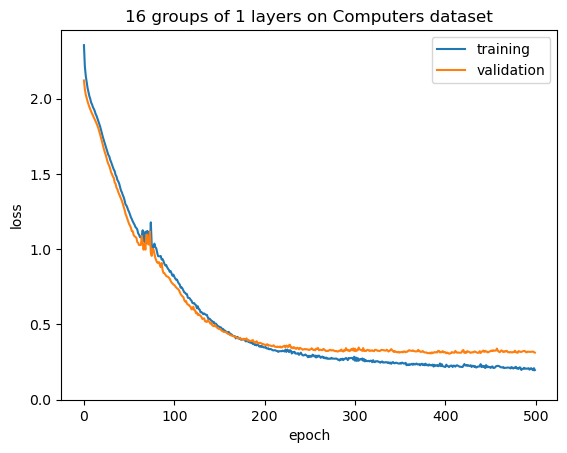

84.63135030004196


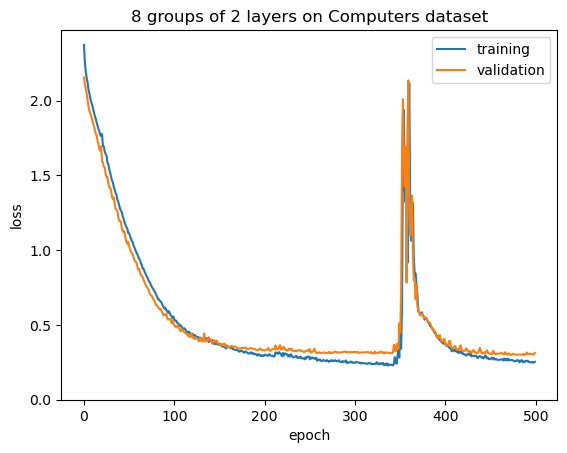

171.46292259998154


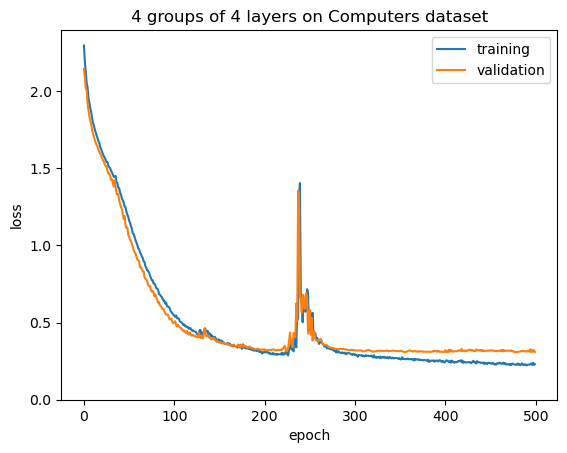

259.54152830003295


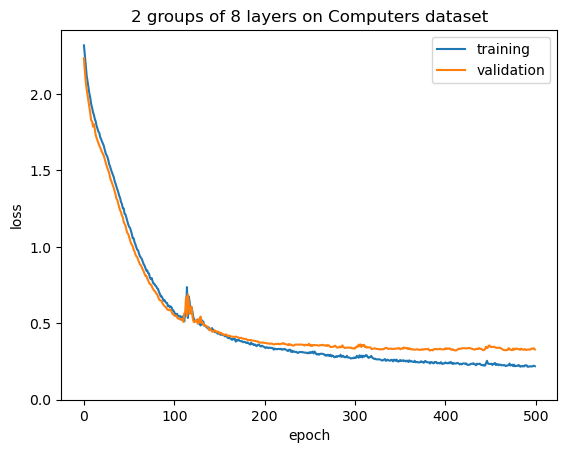

347.4614108999958


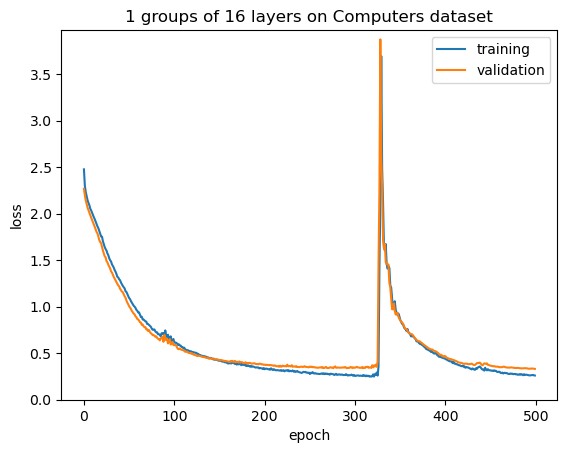

435.35359800001606
[tensor(0.9187, device='cuda:0'), tensor(0.9031, device='cuda:0'), tensor(0.9155, device='cuda:0'), tensor(0.9103, device='cuda:0'), tensor(0.8943, device='cuda:0')]


<Figure size 640x480 with 0 Axes>

In [105]:
torch.manual_seed(1)
np.random.seed(1)
start=timer()

computers_train,computers_val,computers_test=train_split(computers)
 
computers_acc = []
computers_wtgroups = [16,8,4,2,1]
for wt_groups in computers_wtgroups:
    computers_acc.append(nodewise_train(computers,computers_train,computers_val,computers_test, 64, 16, wt_groups, epochs=500,
                               plt_title="{} groups of {} layers on Computers dataset".format(wt_groups, 16//wt_groups)))
    print(timer()-start)
print(computers_acc)
computers_acc = torch.stack(computers_acc).tolist()

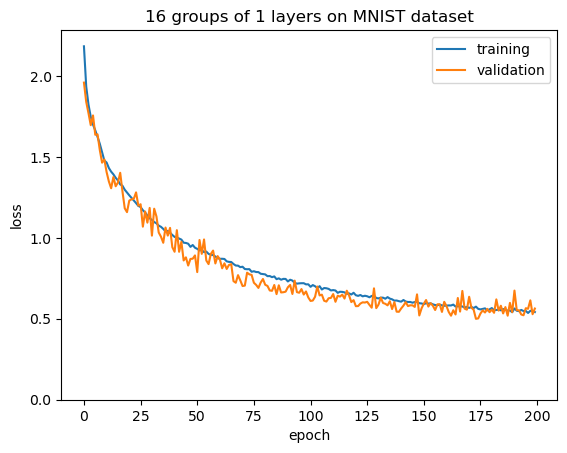

7049.392533899983


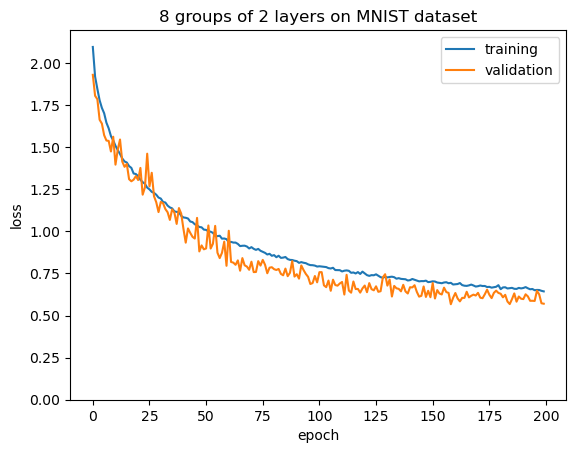

14045.490381199983


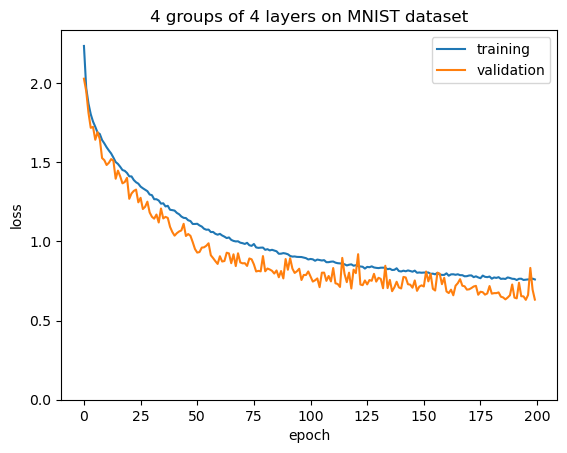

18372.323572299967


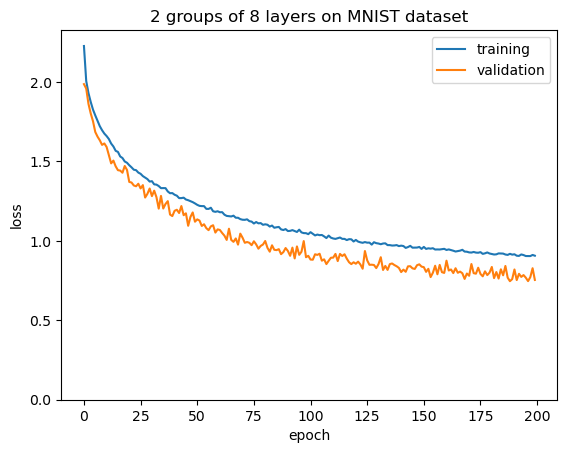

22228.073681799986


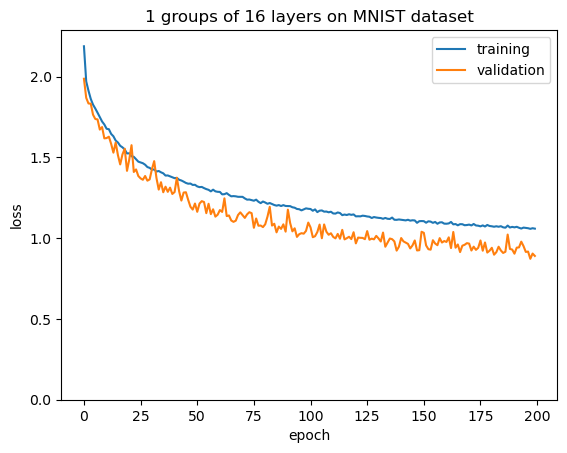

25983.08534509997
[tensor(0.8220, device='cuda:0'), tensor(0.8192, device='cuda:0'), tensor(0.7954, device='cuda:0'), tensor(0.7539, device='cuda:0'), tensor(0.6999, device='cuda:0')]


<Figure size 640x480 with 0 Axes>

In [9]:
#Important: each model takes 1-2 hours to train on local GPU
torch.manual_seed(1)
np.random.seed(1)
start=timer()

mnist_train,mnist_val,mnist_test=train_split(mnist,graph_wise=True)

mnist_acc = []
mnist_wtgroups = [16,8,4,2,1]
for wt_groups in mnist_wtgroups:
    mnist_acc.append(graphwise_train(mnist_train,mnist_val,mnist_test, 64, 16,wt_groups, epochs=200,
                               plt_title="{} groups of {} layers on MNIST dataset".format(wt_groups, 16//wt_groups)))
    print(timer()-start)
print(mnist_acc)
mnist_acc = torch.stack(mnist_acc).tolist()

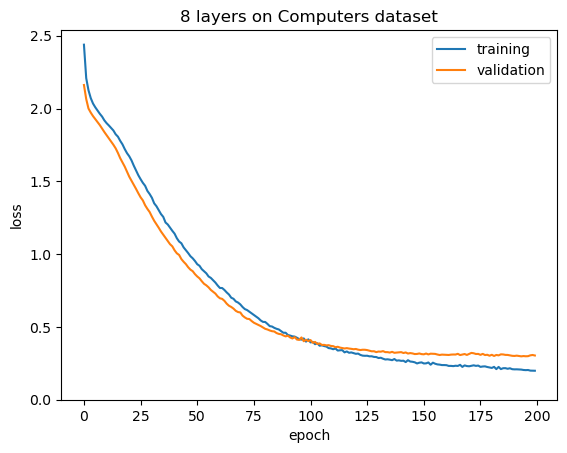

18.20465209998656


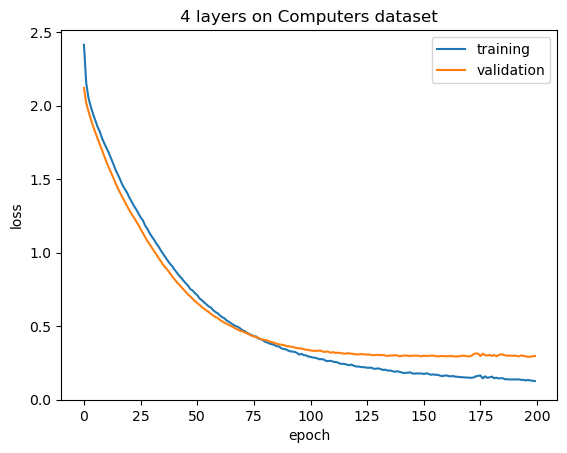

27.95024649996776


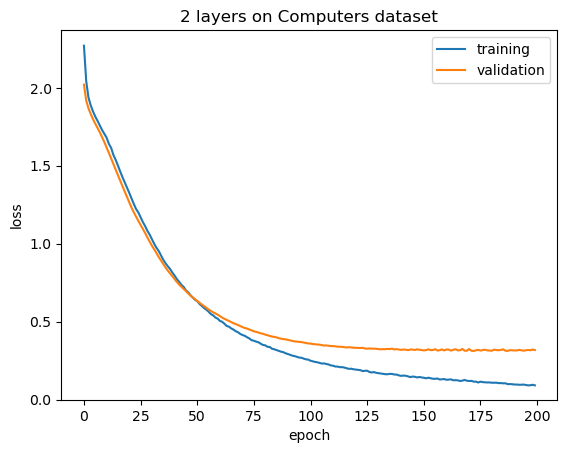

33.29533780005295


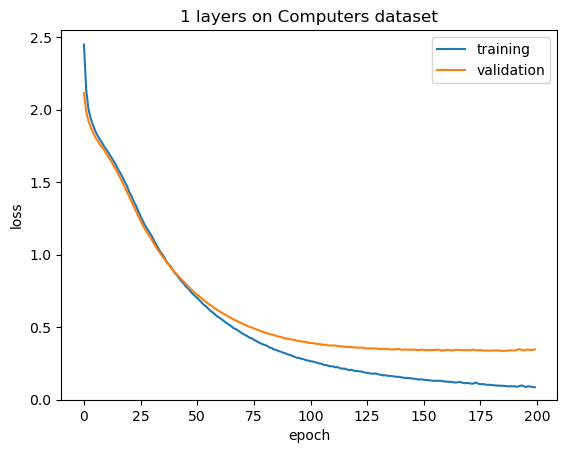

36.69982610002626
[tensor(0.9176, device='cuda:0'), tensor(0.9140, device='cuda:0'), tensor(0.9089, device='cuda:0'), tensor(0.8929, device='cuda:0')]


<Figure size 640x480 with 0 Axes>

In [106]:
torch.manual_seed(1)
np.random.seed(1)
start=timer()

computers_acc2 = []
for wt_groups in computers_wtgroups[1:]:
    computers_acc2.append(nodewise_train(computers,computers_train,computers_val,computers_test, 64, wt_groups, wt_groups, epochs=200,
                               plt_title="{} layers on Computers dataset".format(wt_groups)))
    print(timer()-start)
print(computers_acc2)
computers_acc2 = torch.stack(computers_acc2).tolist()
computers_acc2.insert(0,computers_acc[0])

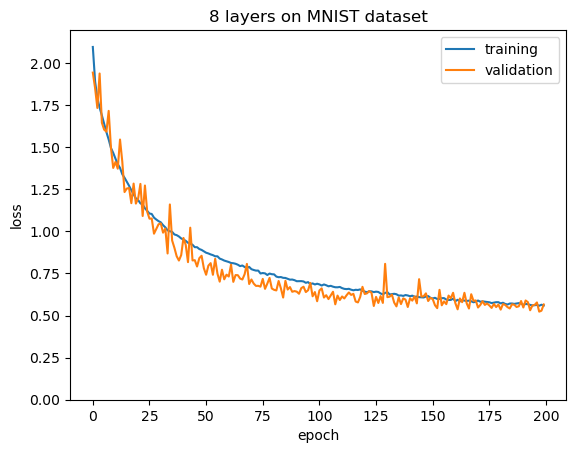

2525.2401909999317


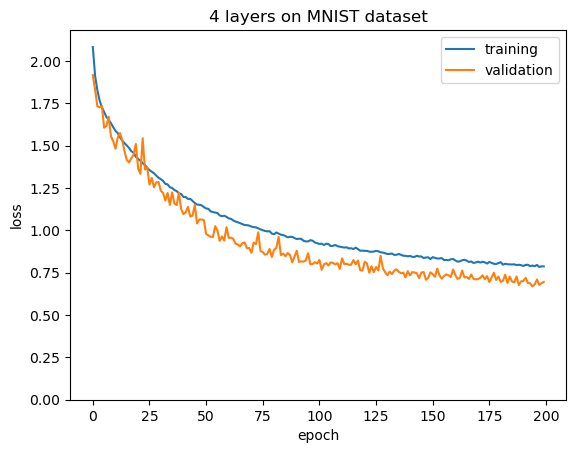

4168.983249899931


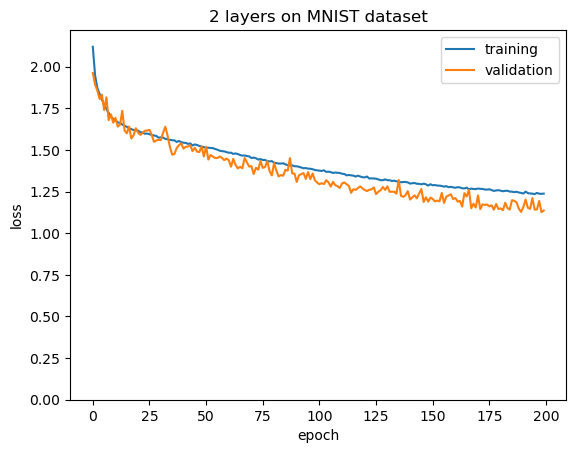

5392.184033199912


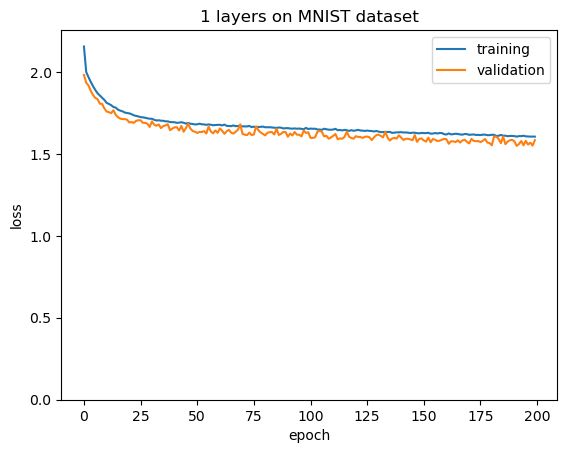

6471.705626699957
[tensor(0.8202, device='cuda:0'), tensor(0.7715, device='cuda:0'), tensor(0.6228, device='cuda:0'), tensor(0.4215, device='cuda:0')]


<Figure size 640x480 with 0 Axes>

In [37]:
torch.manual_seed(1)
np.random.seed(1)
start=timer()

mnist_acc2 = []
for wt_groups in mnist_wtgroups[1:]:
    mnist_acc2.append(graphwise_train(mnist_train,mnist_val,mnist_test, 64, wt_groups,wt_groups, epochs=200,
                               plt_title="{} layers on MNIST dataset".format(wt_groups)))
    print(timer()-start)
print(mnist_acc2)
mnist_acc2 = torch.stack(mnist_acc2).tolist()
mnist_acc2.insert(0,mnist_acc[0])

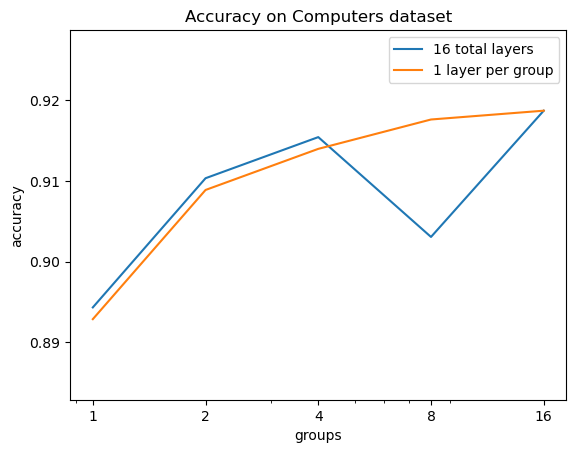

<Figure size 640x480 with 0 Axes>

In [107]:
fig, ax = plt.subplots()
plt.plot(computers_wtgroups,computers_acc,label="16 total layers")
plt.plot(computers_wtgroups,computers_acc2,label="1 layer per group")
plt.title("Accuracy on Computers dataset")
plt.legend()
plt.ylabel("accuracy")
plt.xlabel("groups")
plt.ylim([np.min([computers_acc,computers_acc2])-0.01,0.01+np.max([computers_acc,computers_acc2])])

ax.set_xscale("log")
ax.set_xticks(computers_wtgroups[::-1])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.show()
plt.clf()


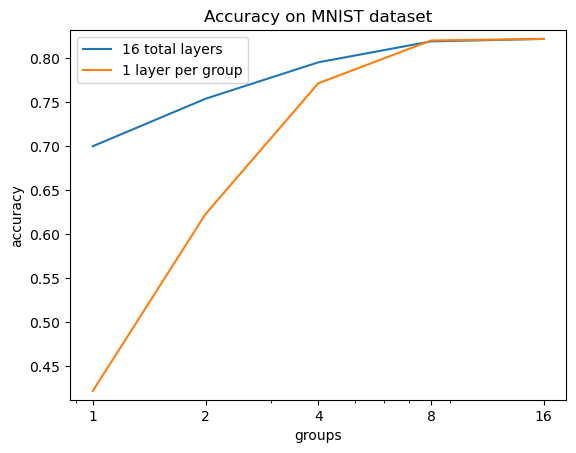

<Figure size 640x480 with 0 Axes>

In [75]:
fig, ax = plt.subplots()
plt.plot(mnist_wtgroups,mnist_acc,label="16 total layers")
plt.plot(mnist_wtgroups,mnist_acc2,label="1 layer per group")
plt.title("Accuracy on MNIST dataset")
plt.legend()
plt.ylabel("accuracy")
plt.xlabel("groups")
plt.ylim([np.min([mnist_acc,mnist_acc2])-0.01,0.01+np.max([mnist_acc,mnist_acc2])])

ax.set_xscale("log")
ax.set_xticks(mnist_wtgroups[::-1])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.show()
plt.clf()


In [108]:
print(np.corrcoef(np.log(computers_wtgroups),computers_acc))
print(np.corrcoef(np.log(computers_wtgroups),computers_acc2))
print(np.corrcoef(np.log(mnist_wtgroups),mnist_acc))
print(np.corrcoef(np.log(mnist_wtgroups),mnist_acc2))


[[1.         0.66768342]
 [0.66768342 1.        ]]
[[1.         0.90711759]
 [0.90711759 1.        ]]
[[1.         0.94994752]
 [0.94994752 1.        ]]
[[1.         0.92065614]
 [0.92065614 1.        ]]


In [110]:
print(computers_acc)
print(computers_acc2)
print(mnist_acc)
print(mnist_acc2)

[0.9187318086624146, 0.9030612707138062, 0.9154519438743591, 0.9103499054908752, 0.8943148851394653]
[0.9187318086624146, 0.9176385402679443, 0.9139941930770874, 0.9088921546936035, 0.8928571939468384]
[0.8220052719116211, 0.8191770315170288, 0.7953653335571289, 0.7539457678794861, 0.6999360918998718]
[0.8220052719116211, 0.8201805949211121, 0.7714624404907227, 0.622753381729126, 0.42149436473846436]
